# Análisis de Umbrales de Similitud en RAG

Este notebook analiza los resultados de un experimento sobre el impacto de diferentes umbrales de similitud (L2) al recuperar documentos en un sistema RAG. El objetivo es comprender cómo varía la cantidad de documentos relevantes recuperados y cómo elegir un umbral apropiado.

El experimento se basa en una base vectorial FAISS con embeddings de tipo `all-MiniLM-L6-v2`. Para cada query, se analizaron los 10 documentos más similares.

In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open("./results.json", encoding="utf-8") as f:
    results = json.load(f)

print(f"Se cargaron {len(results)} queries.")


Se cargaron 30 queries.


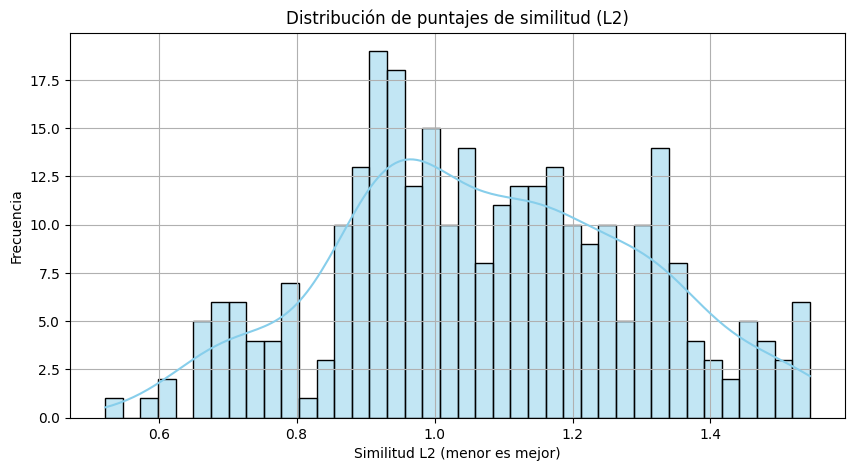

In [6]:
all_scores = []
for entry in results:
    for chunk in entry["chunk_scores"]:
        all_scores.append(chunk["score"])

plt.figure(figsize=(10, 5))
sns.histplot(all_scores, bins=40, kde=True, color='skyblue')
plt.title("Distribución de puntajes de similitud (L2)")
plt.xlabel("Similitud L2 (menor es mejor)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


### Distribución de puntajes de similitud (L2)

La distribución de las distancias L2 muestra un rango concentrado principalmente entre 0.7 y 1.3. Este comportamiento indica que la mayoría de los fragmentos recuperados están relativamente cerca semánticamente de las queries, aunque también hay una cola derecha que muestra presencia de documentos más lejanos.

Esto justifica usar umbrales finos (por ejemplo, cada 0.1) en este rango central, ya que pequeñas variaciones en el umbral pueden tener un impacto significativo en la selección de documentos relevantes.


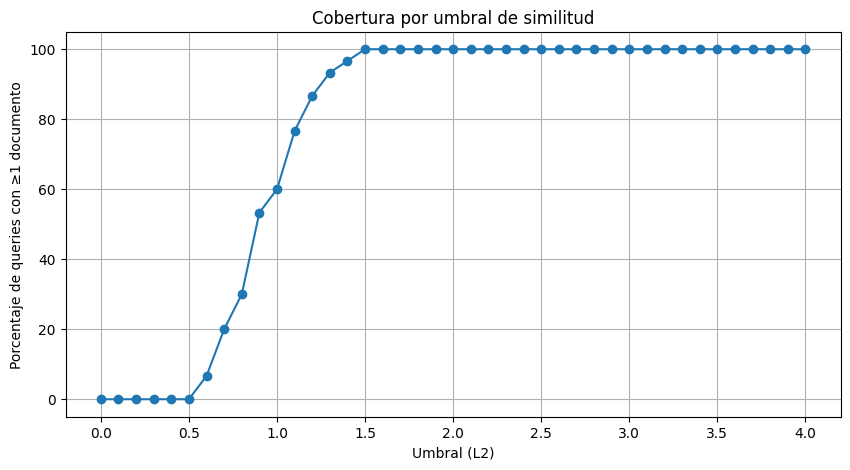

In [7]:
thresholds = sorted([
    float(t) for t in results[0]["retrieved_by_threshold"].keys()
])

coverage = []
for t in thresholds:
    count = sum(
        len(entry["retrieved_by_threshold"][str(t)]) > 0
        for entry in results
    )
    coverage.append(count / len(results) * 100)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, coverage, marker="o")
plt.title("Cobertura por umbral de similitud")
plt.xlabel("Umbral (L2)")
plt.ylabel("Porcentaje de queries con ≥1 documento")
plt.grid(True)
plt.show()


### Cobertura por umbral de similitud

Podemos observar que:

- Con umbrales menores a 0.6, prácticamente ninguna query recupera documentos.
- A partir de 0.9 la cobertura supera el 50%.
- Con umbral 1.2 se alcanza más del 90% de cobertura.
- Umbrales ≥1.5 recuperan resultados para todas las queries.

Esto sugiere que umbrales demasiado bajos son muy estrictos, mientras que valores entre 1.0 y 1.4 ofrecen un buen balance entre filtrado y cobertura. Umbrales por encima de 2.0 probablemente añadan fragmentos de menor calidad semántica.


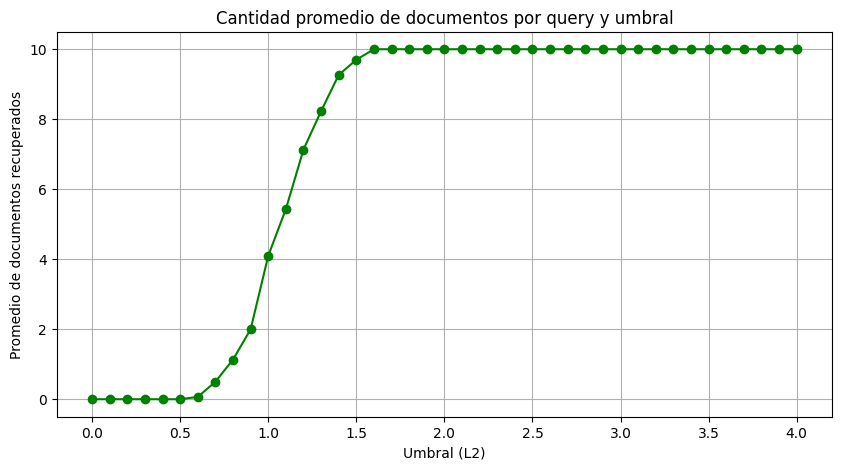

In [8]:
avg_chunks = []
for t in thresholds:
    total = sum(
        len(entry["retrieved_by_threshold"][str(t)])
        for entry in results
    )
    avg = total / len(results)
    avg_chunks.append(avg)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, avg_chunks, marker="o", color="green")
plt.title("Cantidad promedio de documentos por query y umbral")
plt.xlabel("Umbral (L2)")
plt.ylabel("Promedio de documentos recuperados")
plt.grid(True)
plt.show()


### Recomendación de umbral

Con base en los datos:

- Un umbral entre 1.0 y 1.3 parece óptimo: se logra buena cobertura sin incluir documentos con similitud muy baja.
- Elegir un umbral menor a 0.9 puede dejar queries sin contexto útil.
- Umbrales superiores a 1.5 ya no aportan ganancia significativa en cobertura y pueden degradar la calidad de los contextos.

Se recomienda usar un umbral inicial de 1.2, y ajustarlo según la calidad de las respuestas posteriormente.
